# Compressing GOES Data using Neural Networks
This tutorial will be going through how neural networks can be used to compress data. 
The topics this tutorial will be going through briefly are
- What is GOES

## What is GOES
Geostationary Operational Environmental Satellites (GOES) is a collaboration between the National Oceanic and Atmospheric Administration (NOAA) and the National Aeronautics and Space Administration (NASA) that provides continuous imagery and data on atmospheric conditions and solar activity.

The data consists of 16 spectral bands, which consist of two visible channels, four near-infrared channels and ten infrared channels. In this tutorial, the data used in this tutorial consists of data collected hourly over a ten week period. 

If you want to learn more about the data, ["A Closer Look at the ABI on the GOES-R Series"](https://journals.ametsoc.org/view/journals/bams/98/4/bams-d-15-00230.1.xml?tab_body=abstract-display) goes into more in detail about it.

## What is FINER
Flexible spectral-bias tuning in implicit neural representation (FINER) uses the activation function $\sin(w(|x| + 1)x)$. Using the sin function allows for the neural network to map from coordinate inputs to corresponding values through the use of a continuous function. 

In order to start this tutorial, the first step is to ensure that all the necessary python libraries are installed by running the cell below.

### Importing packages

In [1]:
import sys
import subprocess
subprocess.run([sys.executable, "-m", "pip", "install", "torch", "torchmetrics", "wandb", "torchinfo", "numcodecs[pcodec]==0.15.1", "xarray==2025.3.1", "zarr==3.0.6"],
              stdout=subprocess.DEVNULL);

This tutorial uses the following python libraries. The line `sys.path.append(os.path.abspath(".."))` allows for functions from the other files in tutorial to be imported easily.

In [2]:
import yaml
import torch
import numpy as np
from torch import nn
import xarray as xr
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import os
from torchmetrics.functional import peak_signal_noise_ratio
# Add the project root to the system path
sys.path.append(os.path.abspath(".."))

The following functions and classes are imported from other files used in this tutorial.
- FinerModel refers to the neural network being used. It uses the activation function $\sin(w_0|x| + 1x)$ as discussed above
- xarray_to_tensor: loads the data given a config file and converts the xarray to a tensor for the given parameters (bands, time, latitude and longitude)
- plot_band_comparison: will be used to plot the actual vs predicted band for the coords
- load_data: This function is called in xarray_to_tensor. While not necessary in this tutorial, if you want to play around with the xarray and learn more about how it works, you can play around with it by using the load_data function to create teh dataset and try filtering with it.
- GoesData: The data structure that stores the band values for each point based on latitude and longitude and the latitude and longitude itself. It allows for the data to be normalized. It also creates batches for batch training. 

In [3]:
from models.inrs import FinerModel
from utils.utils import xarray_to_tensor, plot_band_comparison, load_data
from train import train_model_with_psnr, train_batches_model_with_psnr
from goes_data import GoesData

The following code will be used to ignore some warnings. It usually is not a good idea to hide the warnings but in this case, the purpose is just to make the tutorial easier to read. 

In [4]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.",
    category=UserWarning,
    module="numcodecs.zarr3"
)

## Exploring GOES data
In order to expore the GOES dataset, run the following code first

In [5]:
data = xr.open_zarr('/notebook_dir/public/mickellals-public/goes-16-2003-10-weeks.tmp.zarr')
data

<xarray.Dataset> Size: 14TB
Dimensions:  (t: 1680, lat: 8133, lon: 8130)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB 203.7 203.7 203.7 203.8 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C10  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C13  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C09  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C11  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C12  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

### Looking at the xarray dataset
Notice that there are three dimensions in the dataset, which are time, latitude and longitude. In this 10 week dataset, there are 1680 points related to time, 8133 latitude points and 8130 longitude points. Every data point (time, latitude, longitude) maps to a value for each band.  

### Viewing data info 
For viewing the data, if the previous code cell did not display all the data, it can be viewed by doing ```data.info``` or ```print(data)```

In [6]:
data.info

<bound method Dataset.info of <xarray.Dataset> Size: 14TB
Dimensions:  (t: 1680, lat: 8133, lon: 8130)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB 203.7 203.7 203.7 203.8 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 889

To view the information of a band, select the band the check the attrs parameter by doing something like ```data['CMI_C08]``` as shown below

In [7]:
data['CMI_C08'].attrs

{'central_band_wavelength': '6.19',
 'long_name': 'ABI Cloud and Moisture Imagery brightness temperature at top of atmosphere',
 'standard_name': 'toa_brightness_temperature',
 'descriptive_name': 'upper-level water vapour',
 'valid_range': [138.05, 311.06],
 'units': 'K',
 'grid_mapping': 'crs'}

To view the data coordinates (different attributes to filter by), use ```.coords```

In [8]:
data.coords

Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB 203.7 203.7 203.7 203.8 ... 6.275 6.295 6.315

To view the indices of the data and some information, use ```.indexes```

In [9]:
data.indexes

Indexes:
    t        DatetimeIndex(['2023-01-01 00:05:06.343806976',
               '2023-01-01 01:05:06.809755008',
               '2023-01-01 02:05:06.023545984',
               '2023-01-01 03:05:06.023548032',
               '2023-01-01 04:05:06.060137088',
               '2023-01-01 05:05:06.933841920',
               '2023-01-01 06:05:06.923732096',
                  '2023-01-01 07:05:06.255952',
               '2023-01-01 08:05:06.899924096',
               '2023-01-01 09:05:06.260182016',
               ...
               '2023-03-11 14:05:06.139953024',
               '2023-03-11 15:05:06.785485056',
               '2023-03-11 16:05:06.714761984',
                  '2023-03-11 17:05:06.146448',
               '2023-03-11 18:05:06.595052032',
               '2023-03-11 19:05:06.741345024',
               '2023-03-11 20:05:06.720649984',
               '2023-03-11 21:05:06.337357952',
               '2023-03-11 22:05:06.555533952',
                  '2023-03-11 23:05:06.653360']

### Filtering the data
In order to filter the data, the two most common methods are using ```.sel()``` and ```.isel()```

Using ```.sel()``` selects matching data. More information can be found [here](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html)

To match what is done in the tutorial, first modify the lon columns to be within the given range. This also highlights how the data can be changed

In [10]:
data = data.assign_coords(lon=((data.lon + 180) % 360 - 180))
data

<xarray.Dataset> Size: 14TB
Dimensions:  (t: 1680, lat: 8133, lon: 8130)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB -156.3 -156.3 -156.3 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C10  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C13  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C09  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C11  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C12  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

In [11]:
lat_min, lat_max = 30, 50
lon_min, lon_max = -60, 60

subset = data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
subset

<xarray.Dataset> Size: 713GB
Dimensions:  (t: 1680, lat: 1000, lon: 3316)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 4kB 30.02 30.04 30.06 30.08 ... 49.96 49.98 50.0
  * lon      (lon) float32 13kB -60.0 -59.98 -59.96 -59.94 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C10  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C13  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C09  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C11  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C12  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

Using ```.isel()``` allows you to select by using indices instead of data values. For more information, view the [documentation for it](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.isel.html)

In [12]:
# Selects the second index
subset = subset.isel(t=2)
subset

<xarray.Dataset> Size: 424MB
Dimensions:  (lat: 1000, lon: 3316)
Coordinates:
    t        datetime64[ns] 8B 2023-01-01T02:05:06.023545984
  * lat      (lat) float32 4kB 30.02 30.04 30.06 30.08 ... 49.96 49.98 50.0
  * lon      (lon) float32 13kB -60.0 -59.98 -59.96 -59.94 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C15  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C02  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C14  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C07  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C05  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    ...       ...
    CMI_C16  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C10  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C13  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C09  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C11  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C12  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

### Plotting the xarray data
In order to plot the data, xarray allows it to be done with matplotlib by using ```.plot``` and selecting a band as seen below

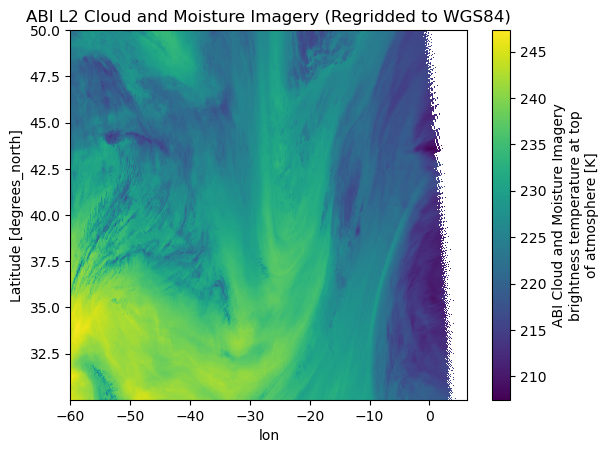

CPU times: user 2.35 s, sys: 387 ms, total: 2.74 s
Wall time: 1.71 s


In [22]:
%%time
subset.CMI_C08.plot(y='lat', x='lon')
plt.title('ABI Cloud and Moisture Imagery brightness temperature at top of atmosphere')
plt.show()

### Loading Data
The following code opens the config file, turns it into a dataset using the GoesData Dataset model, then normalizes the data to be between [-1, 1].
Normalizing the data is important in order to ensure that the gradients do not get to high or get too low. If the gradient got too high or too low, then when doing gradient descent and computing the loss, it makes the weights too large or too small.

In [14]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
dataset =  GoesData(config)
dataset.normalize()

The config file looks as follows:
```yaml
model:
  name: FINER
  in_features: 2          # lat, lon       # predicted GOES value
  hidden_features: 256
  hidden_layers: 2
  first_omega_0: 30.0
  hidden_omega_0: 30.0
  first_k: .6
  hidden_k: .6
  bias: true
  first_bias_scale: null
  scale_req_grad: false
  
data:
    file_addr: /notebook_dir/public/mickellals-public/goes-16-2003-10-weeks.tmp.zarr
    normalize: true
    bands: ["CMI_C07", "CMI_C08", "CMI_C10"]
    lat_min: 35
    lat_max: 45
    lon_min: -100
    lon_max: -75
    time_slice: 0
    
train:
    batch_size: 256
    epochs: 1000
```

For loading the data, the data portion of the config file is used. The ```load_data``` function under ```utils/utils.py``` selects the patch of time used based on the config file from the data portion. The parameters in the data section do the following:
- ```file_addr```: where the data is stored
- ```normalize```: whether or not the data should be normalized to be between [-1, 1]
- ```bands```: which bands should be included in the compression
- ```lat_min```: the minimum latitude to use (smallest is -90)
- ```lat_max```: the maximum latitude value to use use (largest is 90)
- ```lon_min```: the minimum longitude value (smallest is 0)
- ```lon_max```: the maximum longitude value (largest is 360)
- ```time_slice```: It picks which index in the list to use for time. 

The function GoesData(config) uses the following functions:
```python
def load_data(config_file):
    """
    Loads the data based on the information from the config file (should be .yaml file).
    It then filters the data based on the yaml file
    config_file: the file which stores the configuration settings for the data
    """
    file_path = config_file['data']['file_addr']
    data = xr.open_zarr(file_path)
    data = data.assign_coords(lon=((data.lon + 180) % 360 - 180))
    
    bands = config_file['data']['bands']
    lat_min = config_file['data']['lat_min']
    lat_max = config_file['data']['lat_max']
    lon_min = config_file['data']['lon_min']
    lon_max = config_file['data']['lon_max']
    time_slice = config_file['data']['time_slice']
    
    data_subset = data[bands]
    data_subset = data_subset.isel(t=time_slice).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    return data_subset  
```
The load data function takes the config file and returns the dataset within the criteria.

The other main function is ```xarray_to_tensor``` 

```python
def xarray_to_tensor(config_file):
    """
    Converts the xarray from the config file to a tensor mapping latitude and longitude to the band values.
    Removes the NaN values
    Args:
        config_file: The yaml file that has the information 
    """
    dataset = load_data(config_file)

    bands = config_file['data']['bands']
    lat = dataset.lat.values
    lon = dataset.lon.values

    tensor = create_tensor_from_dataset(dataset, bands)
    coords = create_coords(lat, lon)

    coords, tensor = filter_valid(coords, tensor)

    return coords, tensor
```

This function uses the load_data function to create an xarray. After creating the xarray, it creates a tensor by creating a tensor of size (latxlon, num bands) which contains the value for each band and by turning the coordinates into a tensor. It then filters out all the tensor values with a NaN value. For more information, view ```utils/utils.py```

In [15]:
model_params = config["model"]
model_params["out_features"] = len(config["data"]["bands"])
model_params

{'name': 'FINER',
 'in_features': 2,
 'hidden_features': 256,
 'hidden_layers': 2,
 'first_omega_0': 30.0,
 'hidden_omega_0': 30.0,
 'first_k': 0.6,
 'hidden_k': 0.6,
 'bias': True,
 'first_bias_scale': None,
 'scale_req_grad': False,
 'out_features': 3}

The following code takes the model section from the config file. It then uses it to create the model. The number of out_features is dependent on the number of bands, which is why it is created separately.

In [16]:
model = FinerModel(in_features=model_params["in_features"], out_features=model_params["out_features"], hidden_layers=model_params["hidden_layers"], 
                   hidden_features=model_params["hidden_features"], first_omega_0=model_params["first_omega_0"], 
                   hidden_omega_0=model_params["hidden_omega_0"], first_k=model_params["first_k"], hidden_k=model_params["hidden_k"], 
                   bias=model_params["bias"])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
psnr_fn = lambda pred, target: peak_signal_noise_ratio(pred, target, data_range=2.0)
model = model.to(device)


In [17]:
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

In [18]:
%%time
trained_model, losses, psnrs = train_batches_model_with_psnr(
    model, optimizer, criterion, loader, psnr_fn, n_epochs = 1
)

CPU times: user 2min 6s, sys: 1min 11s, total: 3min 17s
Wall time: 11.9 s


In [19]:
checkpoint = {
    'model_state_dict': trained_model.state_dict(),
    'coords': dataset.coords,
    'coords_min': dataset.coords_min,
    'coords_max': dataset.coords_max,
    'gt': dataset.tensor,
    'tensor_min': dataset.tensor_min,
    'tensor_max': dataset.tensor_max,
    'loss_history': losses,
    'psnr_history': psnrs,
}

torch.save(checkpoint, 'goes_model_coords_4096.pth')

In [21]:
with torch.no_grad():
    predictions = model(dataset.coords)
    loss = criterion(predictions, dataset.tensor)
    print(f"Loss on training data: {loss.item():.6f}")

Loss on training data: 0.181760
